In [1]:
import numpy as np 
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold, GroupKFold

from sklearn.ensemble import VotingRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

pd.set_option('display.max_columns', None)
#########################################################
train = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')

In [2]:
train.shape

(6036000, 8)

In [3]:
test.shape

(4024000, 7)

# Quick Data Exploration

In [4]:
print(f'Length of TRAIN dataset: {len(train)}')
print(f'Length of TEST dataset: {len(test)}')
print('')
print('Missing values in TRAIN dataset')
for i in train.iloc[:, 0:-1].columns.tolist():
    print(f'{i}: {train[i].isna().sum()}')
print('')
print('Missing values in TEST dataset')
for i in train.iloc[:, 0:-1].columns.tolist():
    print(f'{i}: {train[i].isna().sum()}')
print('')
print(f'Number of breaths in train dataset: {train["breath_id"].nunique()}')
print(f'Number of breaths in test dataset: {test["breath_id"].nunique()}')
print(f'The number of observations for each breath: {train["breath_id"].value_counts().reset_index()}')

Length of TRAIN dataset: 6036000
Length of TEST dataset: 4024000

Missing values in TRAIN dataset
id: 0
breath_id: 0
R: 0
C: 0
time_step: 0
u_in: 0
u_out: 0

Missing values in TEST dataset
id: 0
breath_id: 0
R: 0
C: 0
time_step: 0
u_in: 0
u_out: 0

Number of breaths in train dataset: 75450
Number of breaths in test dataset: 50300
The number of observations for each breath:        breath_id  count
0              1     80
1          83891     80
2          83924     80
3          83923     80
4          83922     80
...          ...    ...
75445      41745     80
75446      41743     80
75447      41742     80
75448      41741     80
75449     125749     80

[75450 rows x 2 columns]


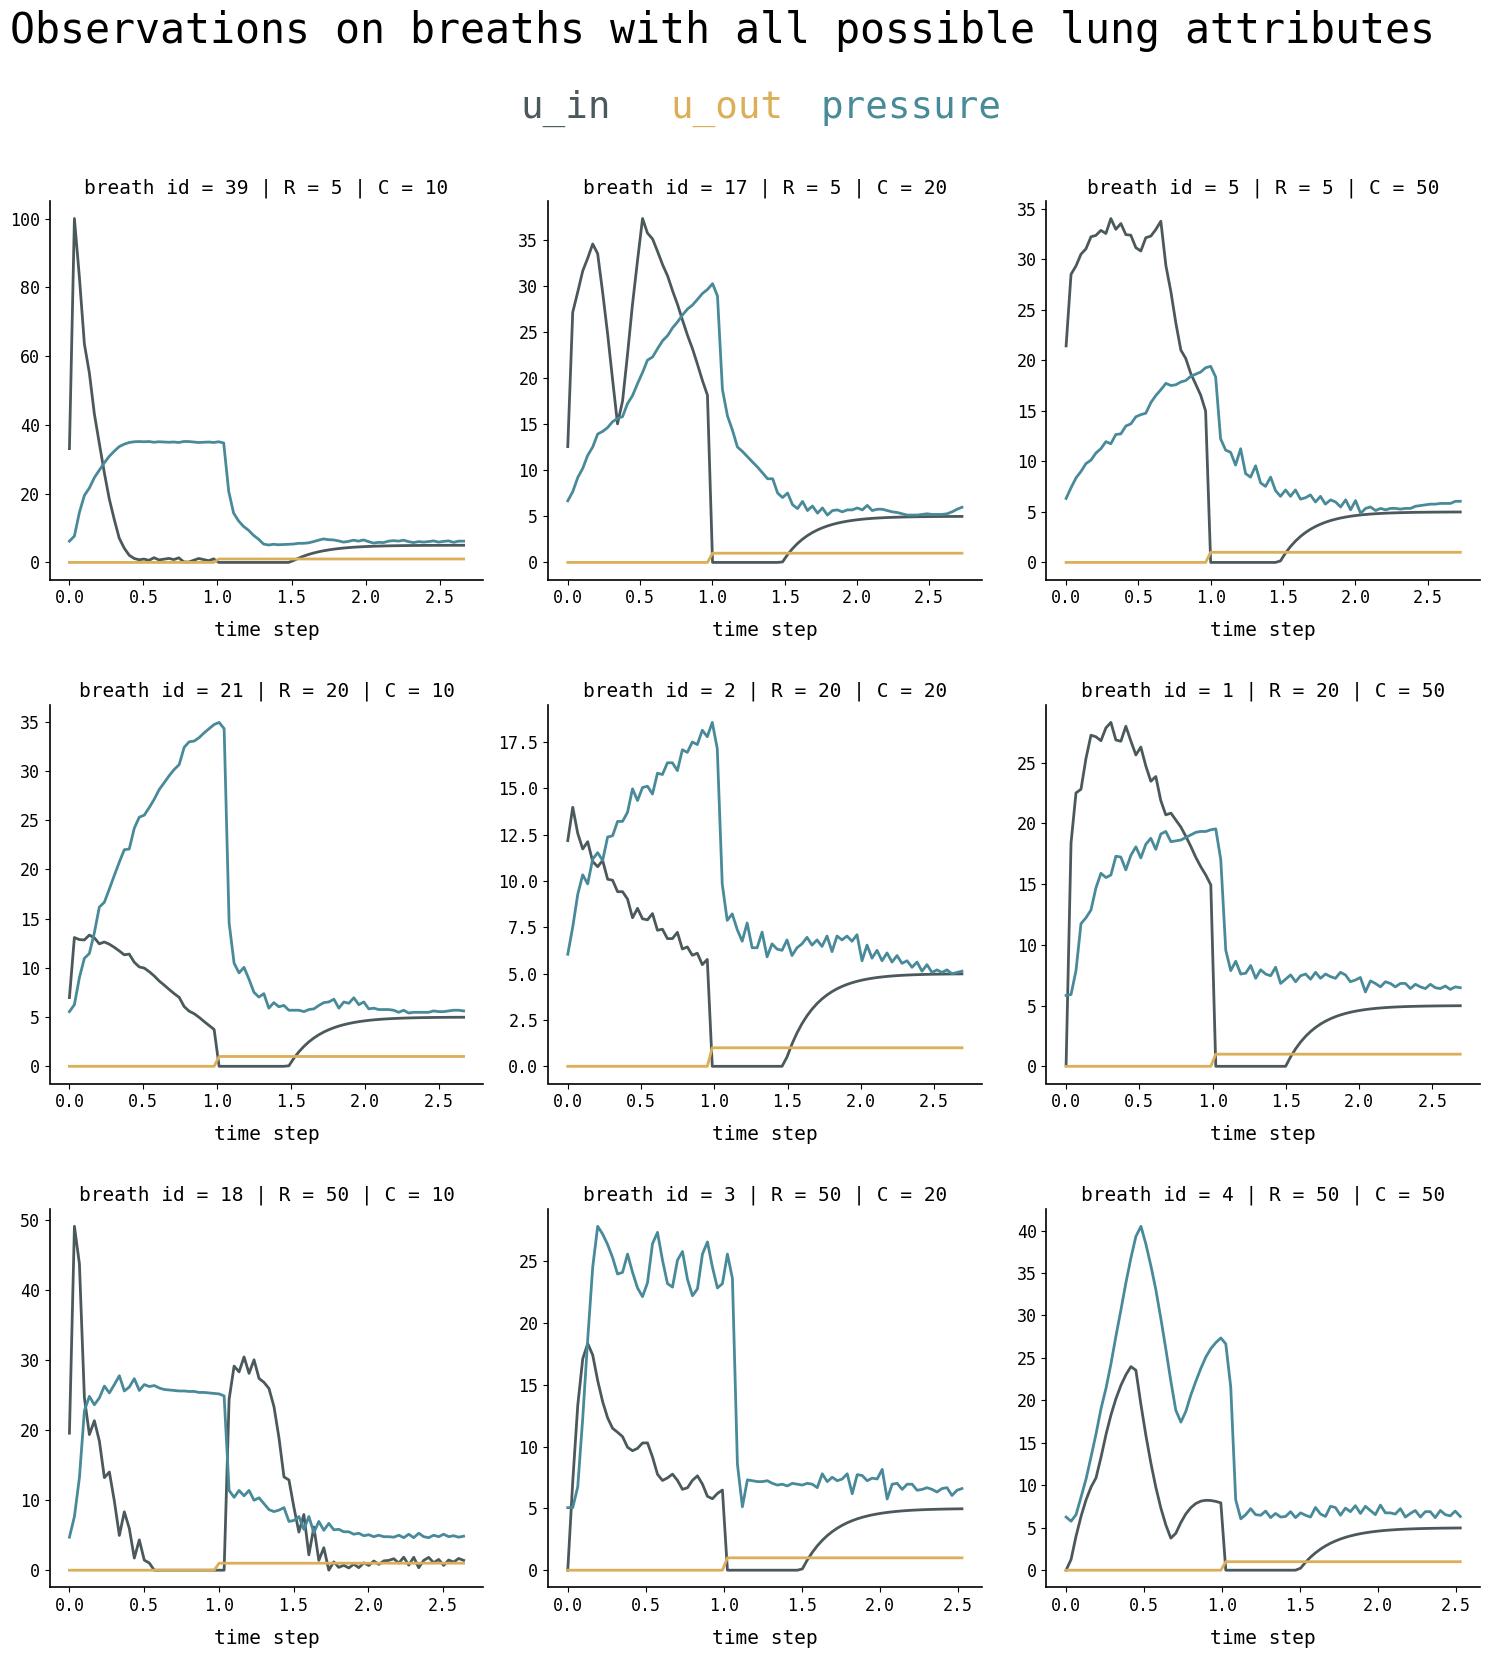

In [7]:
fig = plt.figure(figsize = (15, 15))
r, c, plot = [5, 20, 50], [10, 20, 50], 1
for i in range(3):
    rr = r[i]
    for k in range(3):
        cc = c[k]
        br_id = train.query('R == @rr & C == @cc').iloc[0,1]
        plt.subplot(3, 3, plot)
        plt.title(f'breath id = {br_id} | R = {rr} | C = {cc}', fontname = 'monospace', size = 14)
        a = sns.lineplot(data = train.query("breath_id == @br_id"), x = "time_step", y = "u_in", color = '#4b585c', linewidth = 2)
        sns.lineplot(data = train.query("breath_id == @br_id"), x = "time_step", y = "u_out", color = '#dbae58', linewidth = 2)
        sns.lineplot(data = train.query("breath_id == @br_id"), x = "time_step", y = "pressure", color = '#488a99', linewidth = 2)
        plt.ylabel('')
        plt.xlabel('time step', size = 14, fontname = 'monospace', labelpad = 10)
        plt.xticks(size = 12, fontname = 'monospace')
        plt.yticks(size = 12, fontname = 'monospace')

        for j in ['right', 'top']:
            a.spines[j].set_visible(False)
        for j in ['bottom', 'left']:    
            a.spines[j].set_linewidth(1.2)
            
        plot += 1

plt.figtext(0.01, 1.08, 'Observations on breaths with all possible lung attributes', fontname = 'monospace', size = 30, color = 'black')
plt.figtext(0.35, 1.03, 'u_in', fontname = 'monospace', size = 27, color = '#4b585c')
plt.figtext(0.45, 1.03, 'u_out', fontname = 'monospace', size = 27, color = '#dbae58')
plt.figtext(0.55, 1.03, 'pressure', fontname = 'monospace', size = 27, color = '#488a99')
fig.tight_layout(h_pad = 3)
plt.show()

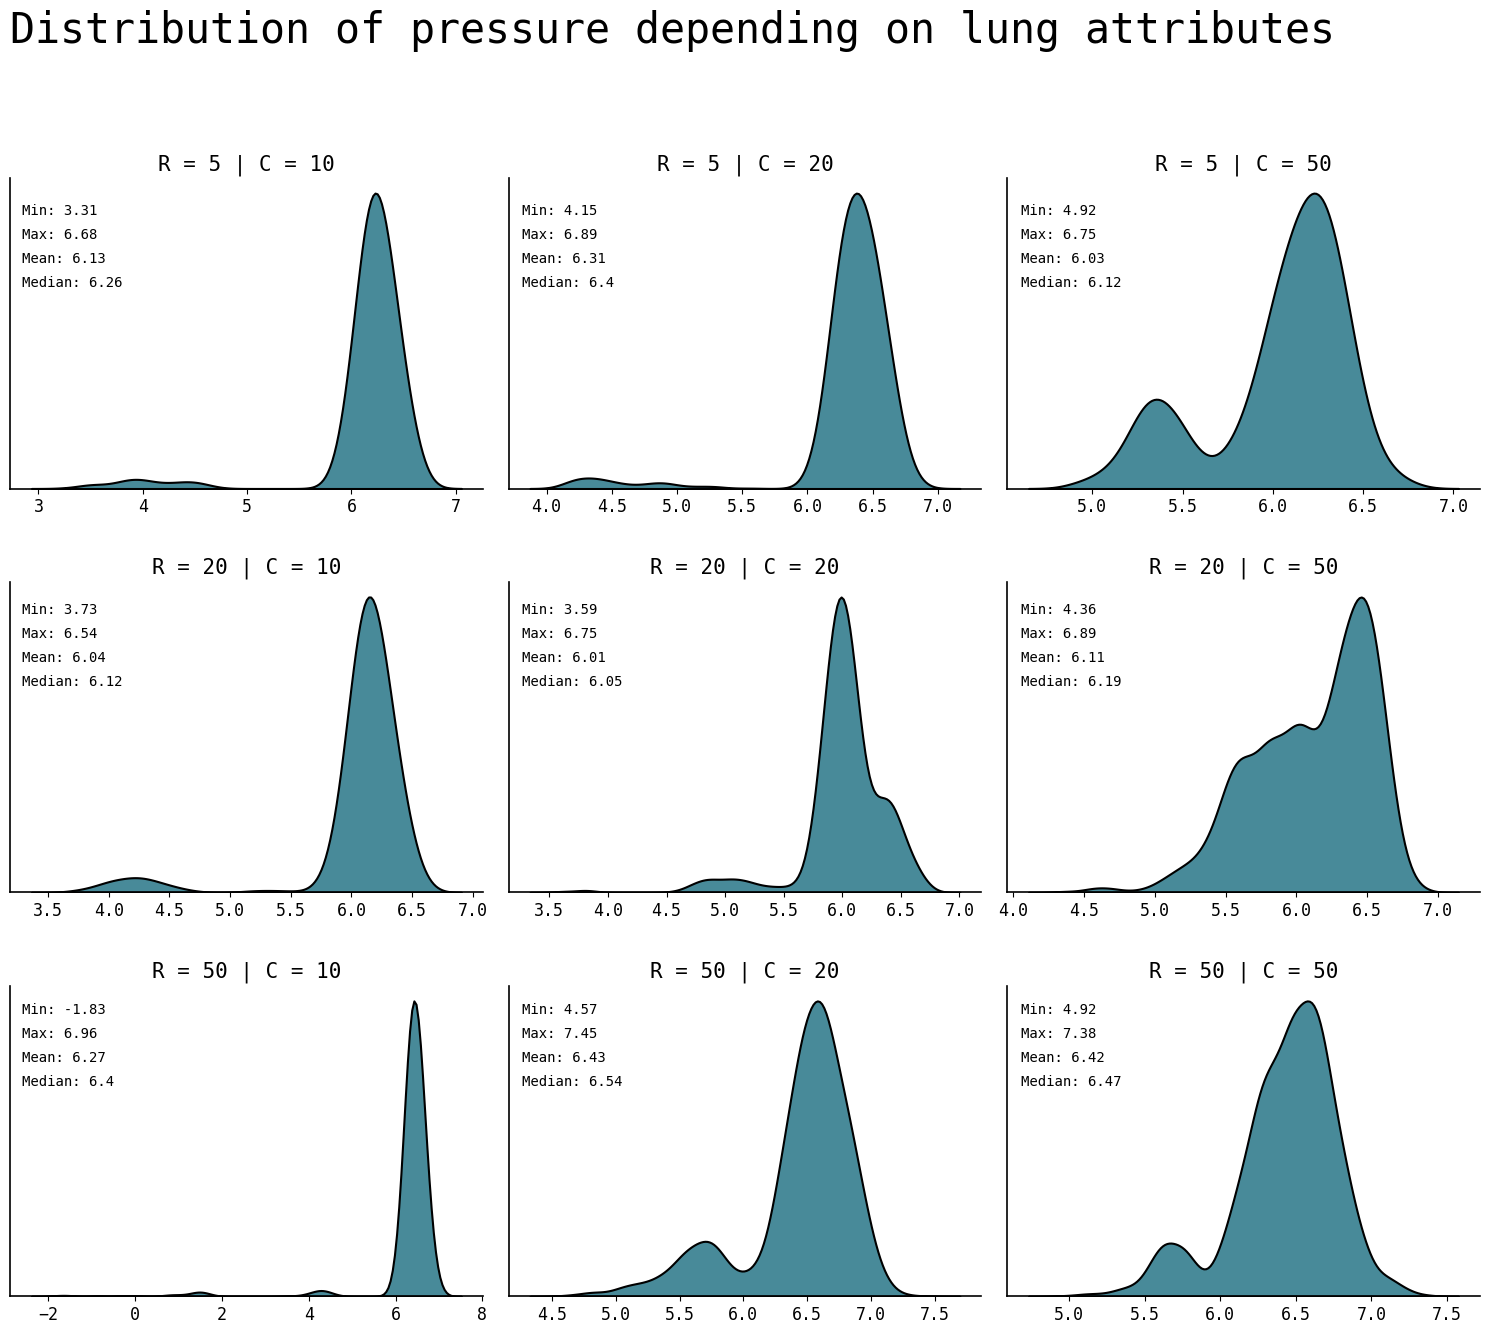

In [8]:
fig = plt.figure(figsize = (15, 12))
plot = 1
for i in range(3):
    rr = r[i]
    for k in range(3):
        cc = c[k]
        plt.subplot(3, 3, plot)
        plt.title(f'R = {rr} | C = {cc}', fontname = 'monospace', size = 15, color = 'black')
        a = sns.kdeplot(train.query('time_step < 0.000001 & u_in < 0.000001 & R == @rr & C == @cc')['pressure'], color = '#488a99', shade = True, alpha = 1, linewidth = 1.5, edgecolor = 'black')
        plt.ylabel('')
        plt.xlabel('')
        plt.xticks(size = 12, fontname = 'monospace')
        plt.yticks([])

        for j in ['right', 'top']:
            a.spines[j].set_visible(False)
        for j in ['bottom', 'left']:    
            a.spines[j].set_linewidth(1.2)
            
        plot += 1

y = 1.27
for i in range(3):
    rr = r[i]
    y -= 0.333
    x = -0.315
    for k in range(3):
        cc = c[k]
        x += 0.333
        plt.figtext(x, y, f'Min: {round(train.query("time_step < 0.000001 & u_in < 0.000001 & R == @rr & C == @cc")["pressure"].min(),2)}', fontname = 'monospace', color = 'black')
        plt.figtext(x, y-0.02, f'Max: {round(train.query("time_step < 0.000001 & u_in < 0.000001 & R == @rr & C == @cc")["pressure"].max(),2)}', fontname = 'monospace')
        plt.figtext(x, y-0.04, f'Mean: {round(train.query("time_step < 0.000001 & u_in < 0.000001 & R == @rr & C == @cc")["pressure"].mean(),2)}', fontname = 'monospace', color = 'black')
        plt.figtext(x, y-0.06, f'Median: {round(train.query("time_step < 0.000001 & u_in < 0.000001 & R == @rr & C == @cc")["pressure"].median(),2)}', fontname = 'monospace', color = 'black')
        
plt.figtext(0.01, 1.08, 'Distribution of pressure depending on lung attributes', fontname = 'monospace', size = 30, color = 'black')
        
fig.tight_layout(h_pad = 3)
plt.show()

In [10]:
train.corr()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
id,1.000000,0.999999,0.001853,0.007222,-0.000199,-0.002380,-0.000089,-0.002402
breath_id,0.999999,1.000000,0.001860,0.007222,-0.000213,-0.002378,-0.000100,-0.002394
R,0.001853,0.001860,1.000000,-0.096070,-0.014535,-0.148120,-0.007594,0.015976
C,0.007222,0.007222,-0.096070,1.000000,0.004936,0.151002,0.003720,-0.036727
time_step,-0.000199,-0.000213,-0.014535,0.004936,1.000000,-0.352276,0.839191,-0.524829
u_in,-0.002380,-0.002378,-0.148120,0.151002,-0.352276,1.000000,-0.416985,0.308136
u_out,-0.000089,-0.000100,-0.007594,0.003720,0.839191,-0.416985,1.000000,-0.614910
pressure,-0.002402,-0.002394,0.015976,-0.036727,-0.524829,0.308136,-0.614910,1.000000


<Axes: >

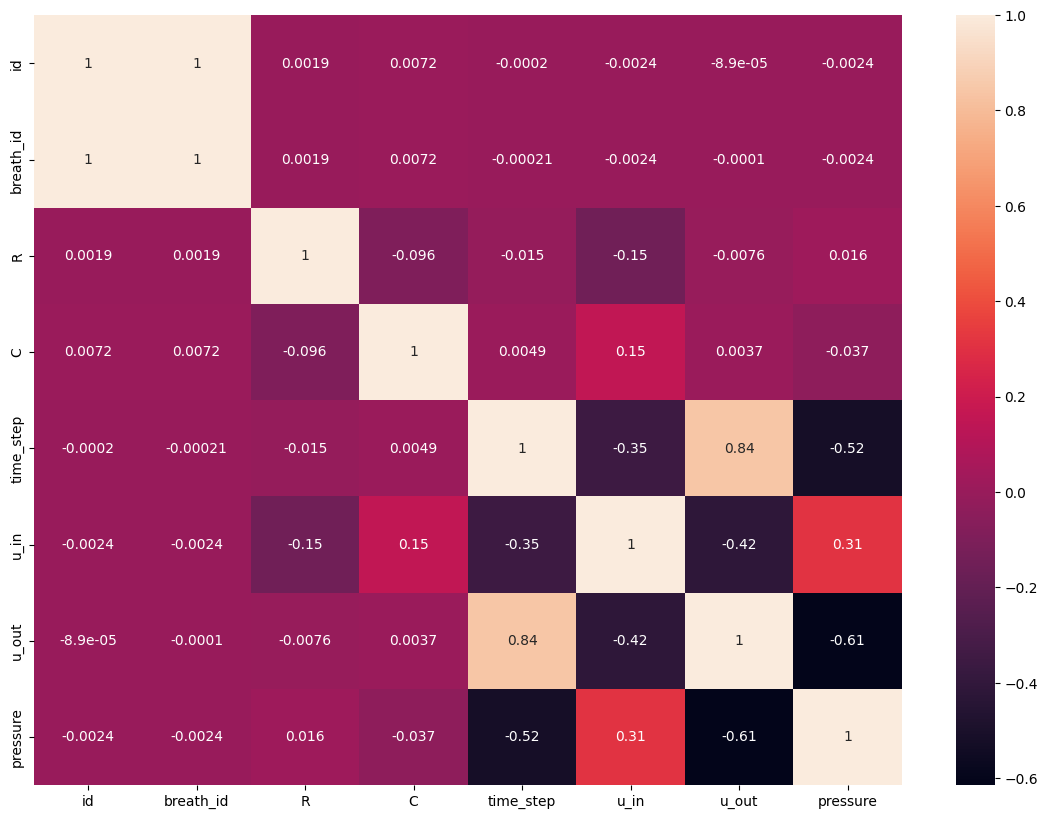

In [12]:
corr_matrix = train.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True)